# Queries

We will use the design produced in [004-Design](./004-Design.ipynb). Please execute that notebook first to define and populate the `app` schema.

## Recall the design

[2023-09-26 23:06:52,800][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-09-26 23:06:52,811][INFO]: Connected root@fakeservices.datajoint.io:3306


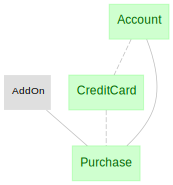

In [1]:
import datajoint as dj
schema = dj.Schema('app')
schema.spawn_missing_classes()
dj.Diagram(schema)

In [2]:
Purchase()

phone,addon_id,card_number
69033213933,2,60402591683
40466455515,2,60403133279
51804464715,2,60412773222
51804464715,3,60412773222
98851803995,2,60417733148
41945689731,3,60427078948
44228721095,3,60446518957
82097048047,1,60446867701
81700356994,1,60450824788
54645599699,2,60451279867


# Queries

## Simple queries

In [3]:
Account()

phone,first_name,last_name,dob
10008004398,Thomas,Li,2009-05-22
10010213238,Stacey,Mitchell,2015-10-02
10012512171,James,Henderson,1920-10-09
10017661220,Donald,Anderson,1955-04-16
10025696662,James,Small,2016-12-29
10037061898,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Martinez,1990-07-15
10068182298,Victor,Clark,1986-09-13
10070173668,Ronald,Duffy,1969-03-23


In [4]:
Account.fetch(as_dict=True)

[{'phone': 10008004398,
  'first_name': 'Thomas',
  'last_name': 'Li',
  'dob': datetime.date(2009, 5, 22)},
 {'phone': 10010213238,
  'first_name': 'Stacey',
  'last_name': 'Mitchell',
  'dob': datetime.date(2015, 10, 2)},
 {'phone': 10012512171,
  'first_name': 'James',
  'last_name': 'Henderson',
  'dob': datetime.date(1920, 10, 9)},
 {'phone': 10017661220,
  'first_name': 'Donald',
  'last_name': 'Anderson',
  'dob': datetime.date(1955, 4, 16)},
 {'phone': 10025696662,
  'first_name': 'James',
  'last_name': 'Small',
  'dob': datetime.date(2016, 12, 29)},
 {'phone': 10037061898,
  'first_name': 'Deborah',
  'last_name': 'Foley',
  'dob': datetime.date(1929, 2, 6)},
 {'phone': 10046294691,
  'first_name': 'Gwendolyn',
  'last_name': 'Turner',
  'dob': datetime.date(2020, 12, 19)},
 {'phone': 10046839321,
  'first_name': 'Marcia',
  'last_name': 'Martinez',
  'dob': datetime.date(1990, 7, 15)},
 {'phone': 10068182298,
  'first_name': 'Victor',
  'last_name': 'Clark',
  'dob': datetim

In [5]:
Account.fetch(as_dict=True, order_by=('last_name', 'first_name'), limit=10)

[{'phone': 51444261372,
  'first_name': 'Alexis',
  'last_name': 'Abbott',
  'dob': datetime.date(1991, 7, 17)},
 {'phone': 71380323330,
  'first_name': 'Emily',
  'last_name': 'Abbott',
  'dob': datetime.date(1913, 10, 23)},
 {'phone': 53177609092,
  'first_name': 'Gregory',
  'last_name': 'Abbott',
  'dob': datetime.date(1930, 4, 21)},
 {'phone': 66079291453,
  'first_name': 'Stephen',
  'last_name': 'Abbott',
  'dob': datetime.date(1916, 9, 7)},
 {'phone': 27358861634,
  'first_name': 'Brandon',
  'last_name': 'Acevedo',
  'dob': datetime.date(1909, 1, 10)},
 {'phone': 98247453638,
  'first_name': 'James',
  'last_name': 'Acevedo',
  'dob': datetime.date(2016, 2, 8)},
 {'phone': 46008885354,
  'first_name': 'Steven',
  'last_name': 'Acevedo',
  'dob': datetime.date(1984, 7, 23)},
 {'phone': 35132860303,
  'first_name': 'Joanna',
  'last_name': 'Acosta',
  'dob': datetime.date(1941, 1, 4)},
 {'phone': 11740091844,
  'first_name': 'Larry',
  'last_name': 'Acosta',
  'dob': datetime.da

In [9]:
Account.fetch(as_dict=True, order_by=('dob DESC'), limit=10, offset=100)

[{'phone': 53932761114,
  'first_name': 'Sara',
  'last_name': 'Shelton',
  'dob': datetime.date(2022, 8, 20)},
 {'phone': 60517459688,
  'first_name': 'Shawn',
  'last_name': 'Cross',
  'dob': datetime.date(2022, 8, 10)},
 {'phone': 10809328694,
  'first_name': 'Tammy',
  'last_name': 'Garcia',
  'dob': datetime.date(2022, 8, 7)},
 {'phone': 66955470314,
  'first_name': 'Kenneth',
  'last_name': 'Sparks',
  'dob': datetime.date(2022, 8, 5)},
 {'phone': 29576059858,
  'first_name': 'Zachary',
  'last_name': 'Ferguson',
  'dob': datetime.date(2022, 8, 2)},
 {'phone': 88537153513,
  'first_name': 'Adam',
  'last_name': 'Thomas',
  'dob': datetime.date(2022, 7, 24)},
 {'phone': 72212204485,
  'first_name': 'Daniel',
  'last_name': 'Hutchinson',
  'dob': datetime.date(2022, 7, 18)},
 {'phone': 63094466207,
  'first_name': 'Lonnie',
  'last_name': 'Tyler',
  'dob': datetime.date(2022, 7, 15)},
 {'phone': 57745712433,
  'first_name': 'Justin',
  'last_name': 'Miles',
  'dob': datetime.date(2

## Restriction (selecting rows)
In SQL, this is the `WHERE` clause. In DataJoint, we use operators `&` and `-`.

In [10]:
Account() & {'phone': 69235537483}

phone,first_name,last_name,dob
69235537483,Michael,Taylor,2022-07-10


In [11]:
Account() & {'first_name': 'Michael'}

phone,first_name,last_name,dob
10229438507,Michael,Coleman,1984-11-23
10454308663,Michael,Smith,1945-08-14
10606206147,Michael,Rasmussen,1955-08-11
10686247769,Michael,Warren,1942-02-11
10789671183,Michael,Rush,1913-12-31
10807995767,Michael,Collins,1958-08-04
10934227204,Michael,Nielsen,2011-01-02
11024050487,Michael,Roberson,1959-05-27
11470574946,Michael,Wilson,2019-12-14
11830659746,Michael,Rodriguez,1936-11-20


In [13]:
Account & 'first_name="Michael"'

phone,first_name,last_name,dob
10229438507,Michael,Coleman,1984-11-23
10454308663,Michael,Smith,1945-08-14
10606206147,Michael,Rasmussen,1955-08-11
10686247769,Michael,Warren,1942-02-11
10789671183,Michael,Rush,1913-12-31
10807995767,Michael,Collins,1958-08-04
10934227204,Michael,Nielsen,2011-01-02
11024050487,Michael,Roberson,1959-05-27
11470574946,Michael,Wilson,2019-12-14
11830659746,Michael,Rodriguez,1936-11-20


In [18]:
Account & 'first_name="Anne"' & 'dob > "2001-01-01"'

phone,first_name,last_name,dob
26784298578,Anne,Weber,2015-04-09
56997124464,Anne,Harris,2006-12-27
71445368084,Anne,Joseph,2004-01-31
80176672017,Anne,Garcia,2009-09-18


In [24]:
Account & 'DATEDIFF(now(), dob) < 300'

phone,first_name,last_name,dob
11866584516,Russell,Kennedy,2023-07-11
13472726485,Robert,Jensen,2023-03-13
16670831184,Linda,Clay,2023-05-08
19363171118,Logan,Brooks,2023-04-26
20316740126,Cindy,Bishop,2023-09-20
22318026657,Christopher,Chavez,2023-03-07
22969160297,Rachel,Holmes,2023-03-12
23952589751,William,Webb,2023-08-06
24814918574,Aaron,Butler,2023-04-05
25922340862,Sharon,Santiago,2023-03-24


In [25]:
Account - 'DATEDIFF(now(), dob) < 300'

phone,first_name,last_name,dob
10008004398,Thomas,Li,2009-05-22
10010213238,Stacey,Mitchell,2015-10-02
10012512171,James,Henderson,1920-10-09
10017661220,Donald,Anderson,1955-04-16
10025696662,James,Small,2016-12-29
10037061898,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Martinez,1990-07-15
10068182298,Victor,Clark,1986-09-13
10070173668,Ronald,Duffy,1969-03-23


In [31]:
millennials = Account & 'dob > "1978-01-01"' & 'dob < "1997-01-01"'

In [33]:
millennials & 'first_name="Michael"'

phone,first_name,last_name,dob
10229438507,Michael,Coleman,1984-11-23
15111017913,Michael,Taylor,1996-02-26
16036134391,Michael,Ford,1978-09-16
16624858863,Michael,Miles,1991-11-14
17173339412,Michael,Morse,1978-09-07
21348118081,Michael,Davila,1979-02-06
22741631510,Michael,Williams,1986-01-09
23202751730,Michael,Dennis,1988-07-27
24034846216,Michael,Thompson,1991-01-20
24551728814,Michael,Farrell,1995-09-23


In [36]:
millennials = Account & 'dob BETWEEN "1978-01-01" AND "1997-01-01"'

In [37]:
millennials

phone,first_name,last_name,dob
10046839321,Marcia,Martinez,1990-07-15
10068182298,Victor,Clark,1986-09-13
10070547405,Leah,Pratt,1986-06-06
10079669194,Ryan,Johnson,1978-03-08
10219719840,Matthew,Roberts,1979-11-21
10229438507,Michael,Coleman,1984-11-23
10291521740,Melissa,Davis,1983-04-26
10337689941,Joshua,Richardson,1979-05-09
10421485185,Julie,Jones,1989-01-11
10433061621,Mark,Whitaker,1994-10-13


# Projection (selecting, calculating, and renaming columns)

In [38]:
Account()

phone,first_name,last_name,dob
10008004398,Thomas,Li,2009-05-22
10010213238,Stacey,Mitchell,2015-10-02
10012512171,James,Henderson,1920-10-09
10017661220,Donald,Anderson,1955-04-16
10025696662,James,Small,2016-12-29
10037061898,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Martinez,1990-07-15
10068182298,Victor,Clark,1986-09-13
10070173668,Ronald,Duffy,1969-03-23


In [39]:
Account.proj()

phone
10008004398
10010213238
10012512171
10017661220
10025696662
10037061898
10046294691
10046839321
10068182298
10070173668


In [42]:
Account.proj('last_name')

phone,last_name
10008004398,Li
10010213238,Mitchell
10012512171,Henderson
10017661220,Anderson
10025696662,Small
10037061898,Foley
10046294691,Turner
10046839321,Martinez
10068182298,Clark
10070173668,Duffy


In [44]:
Account.proj(..., '-dob')

phone,first_name,last_name
10008004398,Thomas,Li
10010213238,Stacey,Mitchell
10012512171,James,Henderson
10017661220,Donald,Anderson
10025696662,James,Small
10037061898,Deborah,Foley
10046294691,Gwendolyn,Turner
10046839321,Marcia,Martinez
10068182298,Victor,Clark
10070173668,Ronald,Duffy


In [47]:
full_name = Account.proj(full_name='concat(last_name, ", ", first_name)')

In [51]:
d = full_name.fetch(order_by="full_name", format="frame")

In [52]:
d

,full_name
phone,
51444261372,"Abbott, Alexis"
71380323330,"Abbott, Emily"
53177609092,"Abbott, Gregory"
66079291453,"Abbott, Stephen"
27358861634,"Acevedo, Brandon"
...,...
67805643956,"Zuniga, Chris"
73169559080,"Zuniga, Erica"
20170335500,"Zuniga, Rachel"


In [59]:
accounts = Account.proj('last_name', age="floor(datediff(now(), dob)/365.25)")

In [60]:
accounts & 'age > 35'

phone,last_name,age calculated attribute
10012512171,Henderson,102
10017661220,Anderson,68
10037061898,Foley,94
10068182298,Clark,37
10070173668,Duffy,54
10070547405,Pratt,37
10079669194,Johnson,45
10099464091,Smith,74
10102995813,Young,99
10116323806,Hernandez,92


In [64]:
accounts & 'age between 35 and 45'

phone,last_name,age calculated attribute
10068182298,Clark,37
10070547405,Pratt,37
10079669194,Johnson,45
10219719840,Roberts,43
10229438507,Coleman,38
10291521740,Davis,40
10337689941,Richardson,44
10460216558,Smith,41
11089394344,Sparks,41
11157317272,Ruiz,37


In [70]:
Account().proj(..., id='phone', name='(first_name)')

id,first_name,name,last_name,dob
10008004398,Thomas,Thomas,Li,2009-05-22
10010213238,Stacey,Stacey,Mitchell,2015-10-02
10012512171,James,James,Henderson,1920-10-09
10017661220,Donald,Donald,Anderson,1955-04-16
10025696662,James,James,Small,2016-12-29
10037061898,Deborah,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Marcia,Martinez,1990-07-15
10068182298,Victor,Victor,Clark,1986-09-13
10070173668,Ronald,Ronald,Duffy,1969-03-23


In [72]:
(Account & 'last_name > "S"').proj()

phone
10025696662
10046294691
10099464091
10102995813
10152397506
10206755444
10358819974
10405413361
10422669197
10433061621


# Restrictions by a query
In SQL, this is a query where the `WHERE` clause includes another `SELECT`` clause.

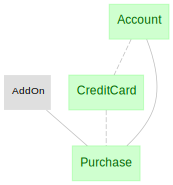

In [74]:
dj.Diagram(schema)

In [76]:
Account & CreditCard

phone,first_name,last_name,dob
10012512171,James,Henderson,1920-10-09
10017661220,Donald,Anderson,1955-04-16
10037061898,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Martinez,1990-07-15
10079669194,Ryan,Johnson,1978-03-08
10099464091,Matthew,Smith,1949-05-04
10102995813,David,Young,1923-12-29
10116323806,Scott,Hernandez,1930-11-01
10120727834,Robert,Rodriguez,1951-04-10


In [77]:
Account - CreditCard

phone,first_name,last_name,dob
10008004398,Thomas,Li,2009-05-22
10010213238,Stacey,Mitchell,2015-10-02
10025696662,James,Small,2016-12-29
10068182298,Victor,Clark,1986-09-13
10070173668,Ronald,Duffy,1969-03-23
10070547405,Leah,Pratt,1986-06-06
10092945283,Deanna,Hayes,2015-08-16
10095918854,Raymond,Adams,2018-05-22
10127762503,Tracy,Mack,1970-04-14
10152397506,James,Wade,1963-04-15


In [83]:
# All the people that purchased AddOn #2.
Account & (Purchase & 'addon_id=2')

phone,first_name,last_name,dob
10153686421,Aaron,Bradley,1912-02-04
10291521740,Melissa,Davis,1983-04-26
10451478023,Diane,Davis,1919-12-31
10496786948,Andrew,Carter,2001-05-02
10734349722,Kenneth,Graves,1932-10-16
10782010443,Amber,Walters,1933-02-12
10844022864,Gary,Rogers,1927-04-10
10862836412,Randy,Sanchez,2018-09-21
11194304584,Matthew,Lucas,2003-03-25
11221407194,Justin,Nelson,1953-04-11


In [88]:
# Give me all accounts who have purchased both Addon 2 and 3
Account & (Purchase & 'addon_id=2') & (Purchase & 'addon_id=3')

phone,first_name,last_name,dob
10496786948,Andrew,Carter,2001-05-02
11883734808,Philip,Black,2014-01-10
12328381833,Louis,Davis,1946-10-09
12966892803,Kathryn,Norman,1913-02-27
15503931605,Robert,Adams,1921-06-04
16065195696,Mathew,Johnson,1981-11-10
16266465922,Mary,Mcpherson,2003-11-23
17386440647,Caleb,Roth,1953-04-11
18690145667,Caleb,Parks,2012-04-18
19361732502,Rodney,Wise,1934-08-11


In [90]:
# Give me all accounts who have purchased Addon 2 or 3
Account & (Purchase & 'addon_id=2 OR addon_id=3')
Account & (Purchase & 'addon_id in (2, 3)')
Account & (Purchase & ['addon_id=3', 'addon_id=2'])

phone,first_name,last_name,dob
10153686421,Aaron,Bradley,1912-02-04
10166849316,Benjamin,Gomez,1929-04-24
10291521740,Melissa,Davis,1983-04-26
10303625356,Rebecca,Griffith,1975-01-10
10451478023,Diane,Davis,1919-12-31
10496786948,Andrew,Carter,2001-05-02
10535081800,John,Mcmahon,1929-01-30
10661381021,Kenneth,Shaffer,1946-09-07
10722472340,Heidi,Callahan,1932-01-05
10734349722,Kenneth,Graves,1932-10-16


In [86]:
# Give me all accounts who have purchased Addon 2 but not 3

In [92]:
# Accounts with credit cards that have no purchases
Account & (CreditCard - Purchase)

phone,first_name,last_name,dob
10012512171,James,Henderson,1920-10-09
10017661220,Donald,Anderson,1955-04-16
10037061898,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Martinez,1990-07-15
10079669194,Ryan,Johnson,1978-03-08
10099464091,Matthew,Smith,1949-05-04
10102995813,David,Young,1923-12-29
10116323806,Scott,Hernandez,1930-11-01
10120727834,Robert,Rodriguez,1951-04-10


In [96]:
# Accounts with credit cards but no purchases
(Account & CreditCard) - Purchase

phone,first_name,last_name,dob
10012512171,James,Henderson,1920-10-09
10017661220,Donald,Anderson,1955-04-16
10037061898,Deborah,Foley,1929-02-06
10046294691,Gwendolyn,Turner,2020-12-19
10046839321,Marcia,Martinez,1990-07-15
10079669194,Ryan,Johnson,1978-03-08
10099464091,Matthew,Smith,1949-05-04
10102995813,David,Young,1923-12-29
10116323806,Scott,Hernandez,1930-11-01
10120727834,Robert,Rodriguez,1951-04-10


## DeMorgan's Laws

NOT (A OR B) == NOT A AND NOT B
NOT (A AND B) == NOT A OR NOT B

NOT (A AND NOT B) == NOT A OR B